## Loading the data

In [1]:
from adjustText import adjust_text
import cpa
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import os 
import scanpy as sc
import seaborn as sns
import torch
from sklearn.metrics import normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_score

sc.set_figure_params(dpi=100, frameon=False)
sc.logging.print_header()

%load_ext autoreload
%autoreload 2

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.7.2 pandas==1.3.4 scikit-learn==1.0.2 statsmodels==0.13.1 pynndescent==0.5.6


In [2]:
torch.__version__

'1.10.0+cu102'

In [3]:
os.getcwd()


'/home/mo/projects/cpa-reproducibility/notebooks'

In [4]:
os.getcwd()
os.chdir("../")

In [5]:
adata = sc.read('./datasets/Norman2019_prep_new.h5ad')
adata

AnnData object with n_obs × n_vars = 108497 × 5000
    obs: 'cov_drug_dose_name', 'dose_val', 'control', 'condition', 'guide_identity', 'drug_dose_name', 'cell_type', 'split', 'split1', 'split2', 'split3', 'split4', 'split5', 'split6', 'split7', 'split8', 'split9', 'split10', 'split11', 'split12', 'split13', 'split14', 'split15', 'split16', 'split17', 'split18', 'split19', 'split20', 'split21', 'split22', 'split23', 'split24', 'split25'
    var: 'gene_symbols', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'rank_genes_groups_cov'
    layers: 'counts'

In [6]:
torch.cuda.is_available()

False

In [7]:
cpa_api = cpa.api.API(
    adata,
    pretrained='./models/norman_splits_models/fig4_model.pt', device="cpu"
)

Loaded pretrained model from:	./models/norman_splits_models/fig4_model.pt


Computation time: 166 min


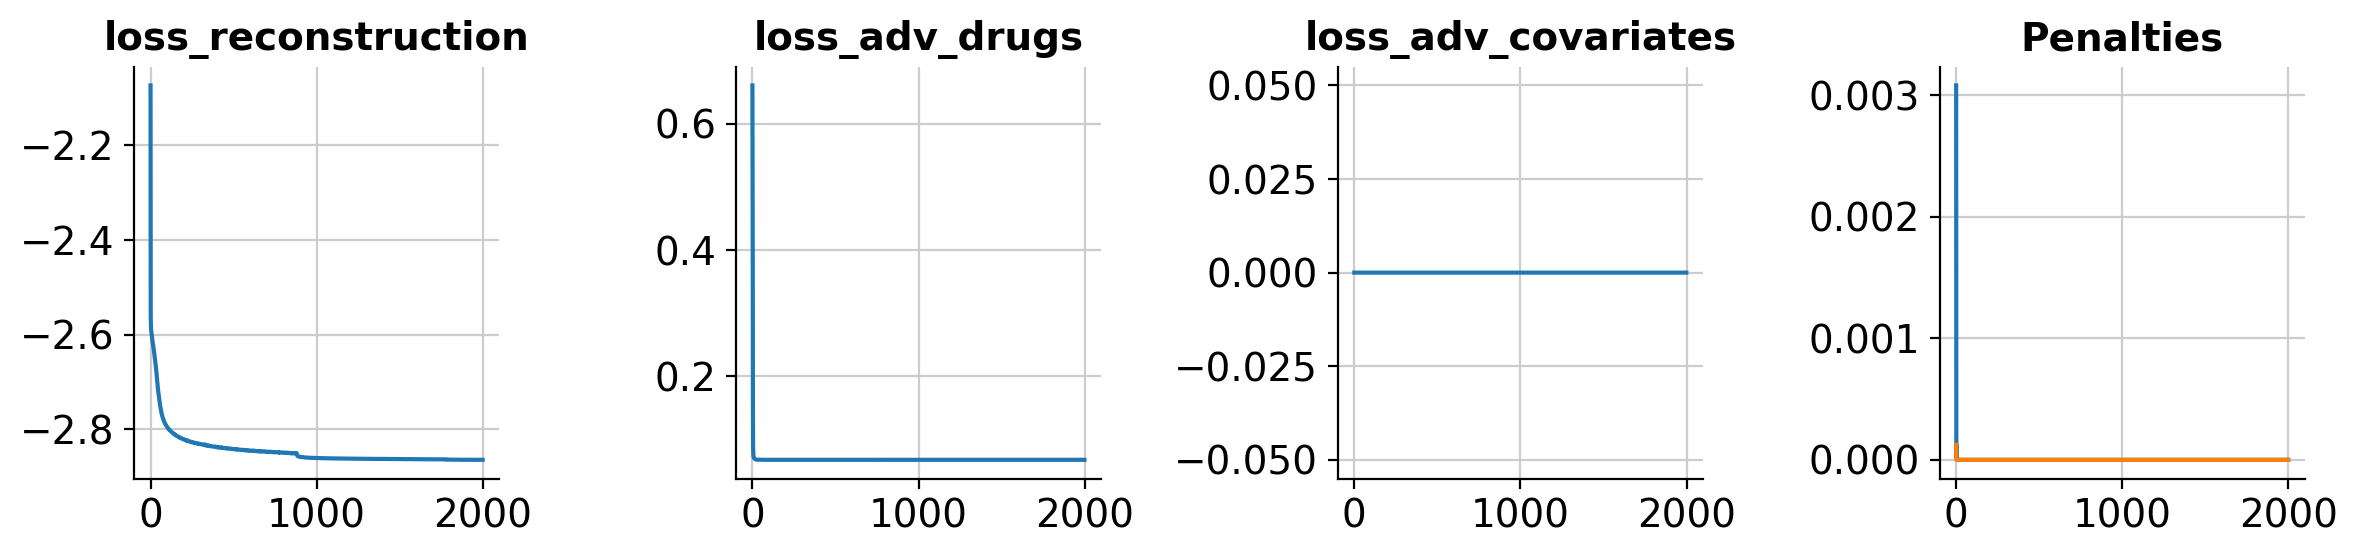

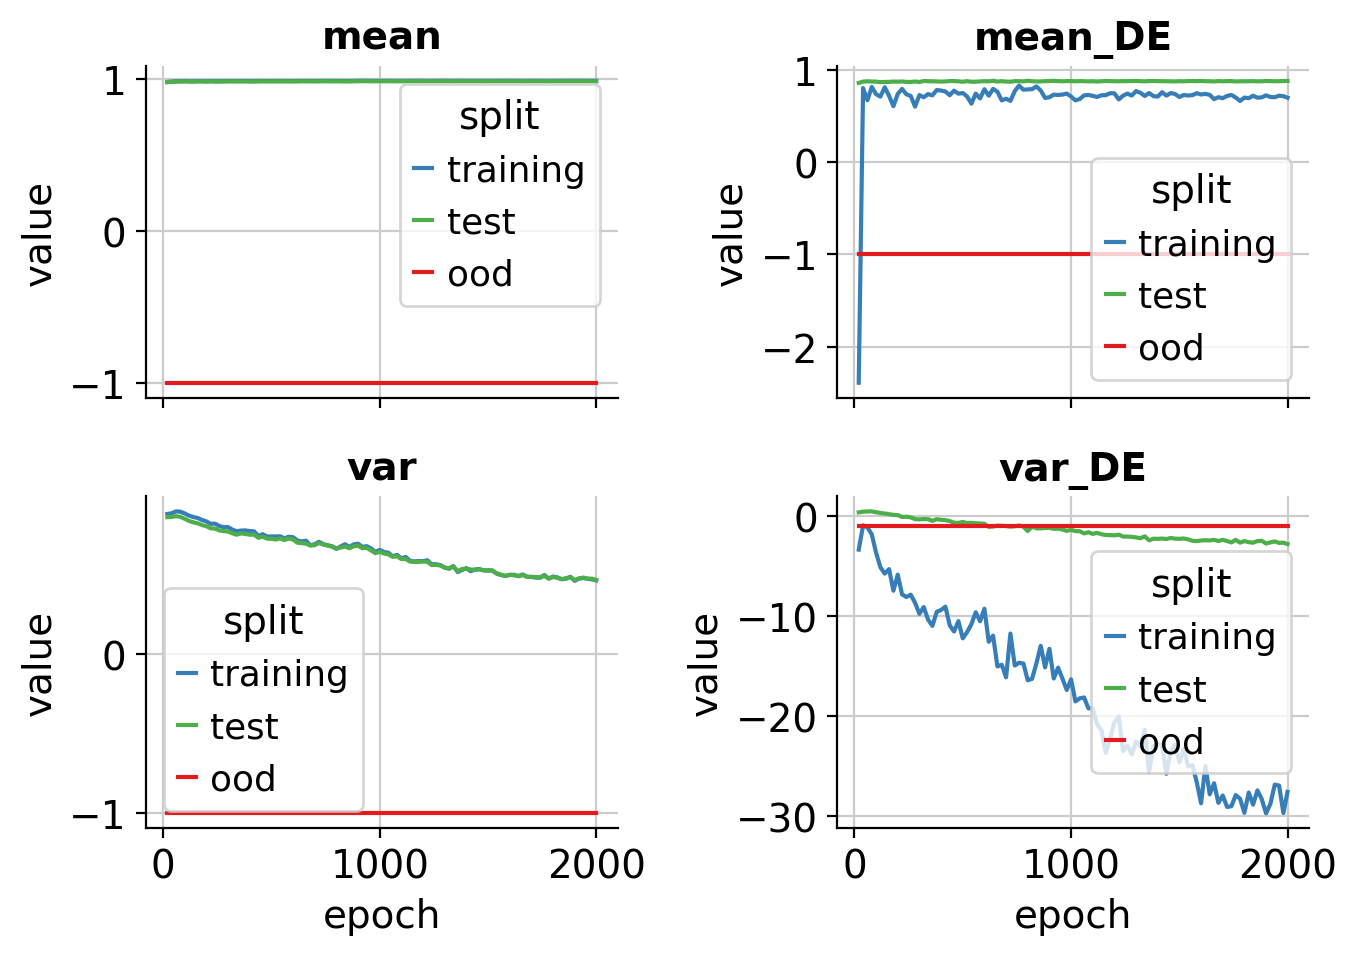

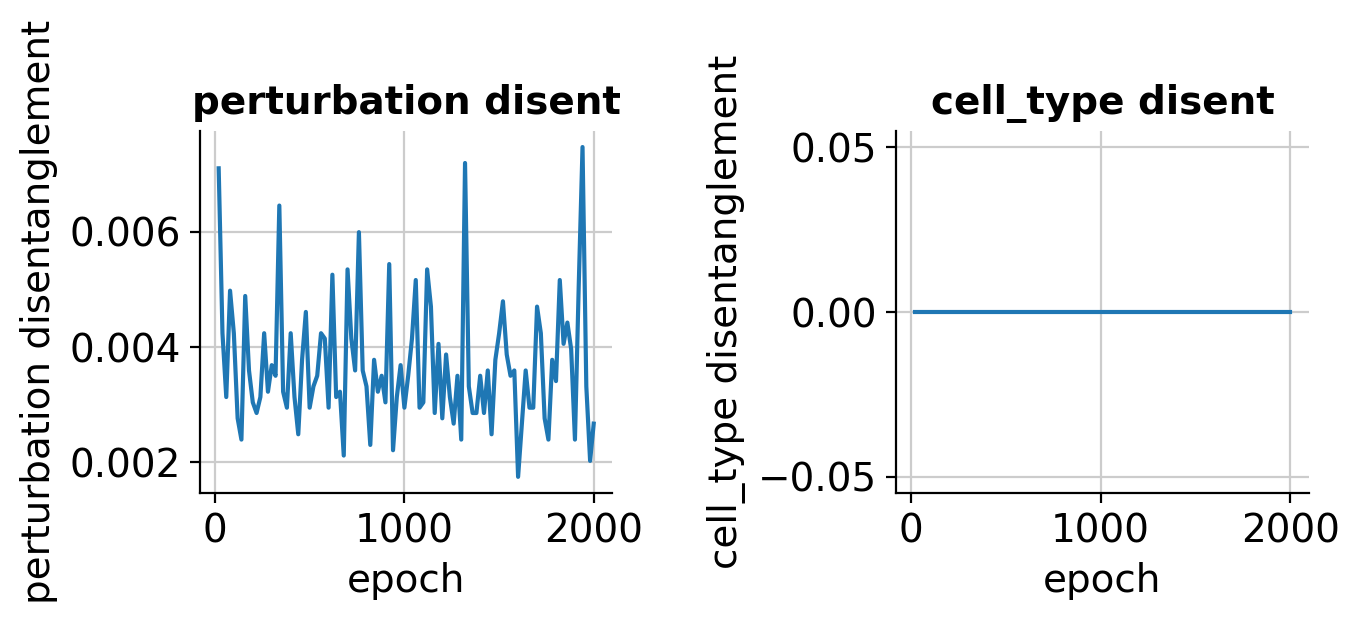

In [8]:
from cpa.plotting import CPAHistory
history = CPAHistory(cpa_api)
history.print_time()
history.plot_losses()
history.plot_r2_metrics()
history.plot_disentanglement_metrics()

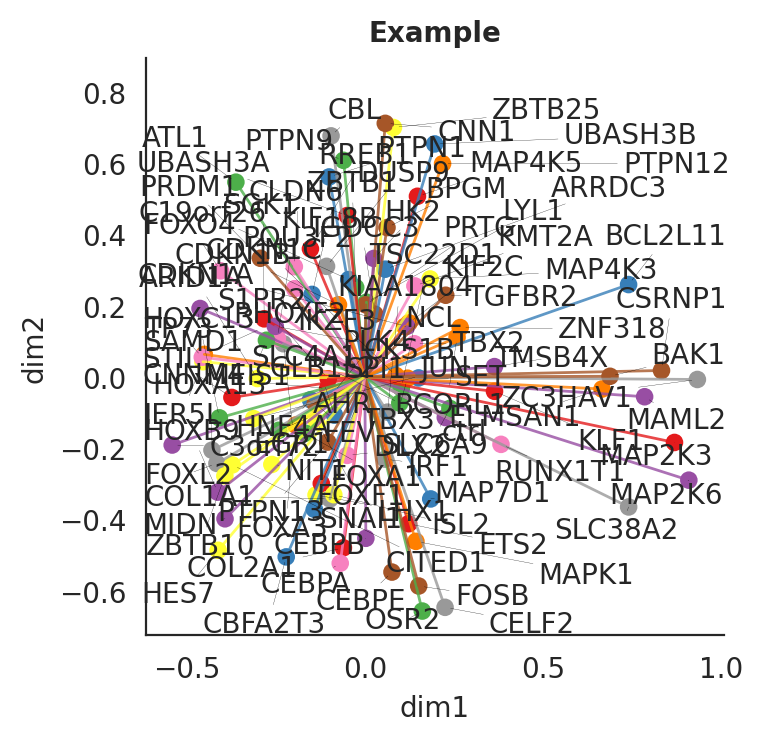

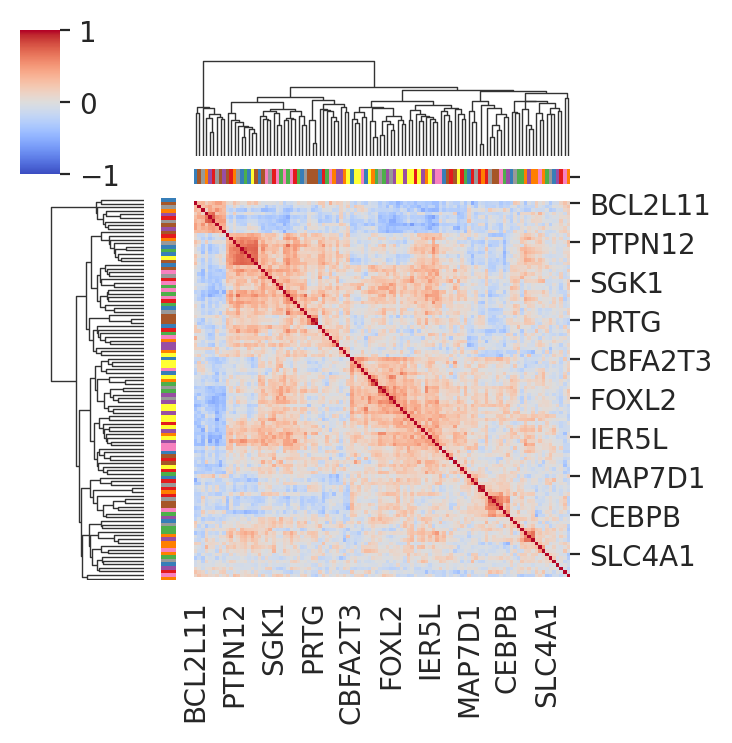

In [9]:
perts_anndata = cpa_api.get_drug_embeddings()
covars_anndata = cpa_api.get_covars_embeddings('cell_type')

cpa_api.compute_comb_emb(thrh=0)
cpa_plots = cpa.plotting.CPAVisuals(cpa_api, fileprefix=None)
cpa_plots.plot_latent_embeddings(cpa_api.emb_perts, kind='perturbations', show_text=True)

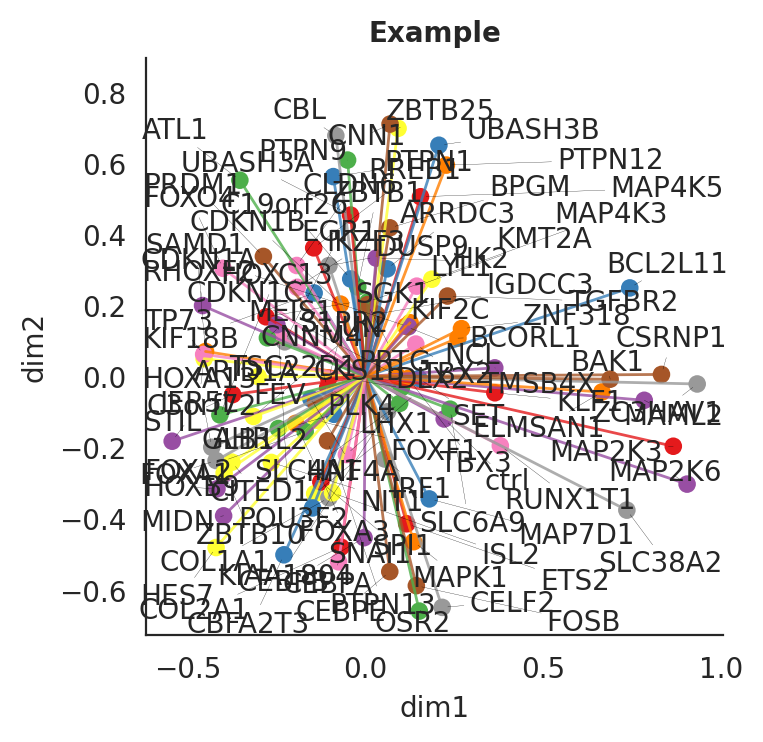

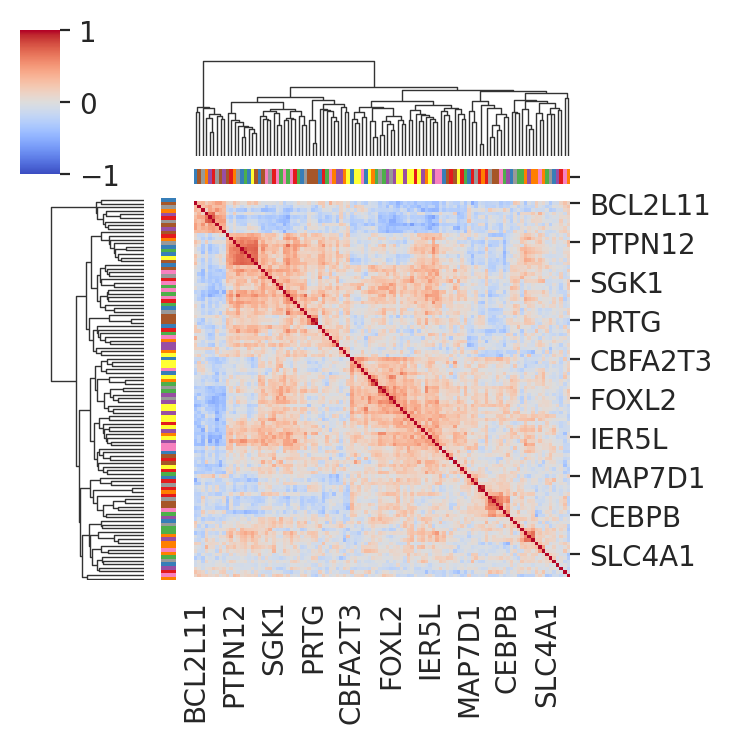

In [10]:
cpa_plots.plot_latent_embeddings(cpa_api.emb_perts + covars_anndata.X, kind='perturbations', show_text=True)

Print and plot drug embeddings.

In [11]:
adata.obs.groupby('split').size()

split
ood          2
test     10848
train    97647
dtype: int64

In [12]:
perts_anndata = cpa_api.get_drug_embeddings()
perts_anndata

AnnData object with n_obs × n_vars = 106 × 64
    obs: 'condition'

In [13]:
condition_key = "condition"

In [14]:
drug_emb_FC = dict(zip(perts_anndata.obs["condition"].tolist(),perts_anndata.X))

combining embeddings

In [15]:
drug_comb_fc = {}
for i in np.unique(adata.obs[condition_key]):
    split = i.split("+")
    temp = np.zeros(perts_anndata.shape[1])
    for j in split:
        temp += drug_emb_FC[j]
    drug_comb_fc[i] = temp

In [16]:
adata_comb = sc.AnnData(X=np.array(list(drug_comb_fc.values())))
adata_comb.obs[condition_key] = list(drug_comb_fc.keys())

In [17]:
g1_cycle = [
    'CDKN1A+ctrl',
    'CDKN1B+CDKN1A',
    'CDKN1B+ctrl',
    'CDKN1C+CDKN1A',
    'CDKN1C+CDKN1B',
    'CDKN1C+ctrl'
]
ERYTHROID = [
    'CBL+CNN1',
    'CBL+PTPN12',
    'CBL+PTPN9',
    'CBL+UBASH3B',
    'SAMD1+PTPN12',
    'SAMD1+UBASH3B','UBASH3B+CNN1',
    'UBASH3B+PTPN12',
    'UBASH3B+PTPN9',
    'UBASH3B+UBASH3A',
    'UBASH3B+ZBTB25',
    'BPGM+SAMD1',
    'PTPN1+ctrl',
    'PTPN12+PTPN9',
    'PTPN12+UBASH3A',
    'PTPN12+ZBTB25',
]
PIONEER_FACTORS = [
    'FOXA1+FOXF1',
    'FOXA1+FOXL2',
    'FOXA1+HOXB9',
    'FOXA3+FOXA1',
    'FOXA3+FOXF1',
    'FOXA3+FOXL2',
    'FOXA3+HOXB9',
    'FOXA3+ctrl',
    'FOXF1+FOXL2',
    'FOXF1+HOXB9',
    'FOXL2+MEIS1',
    'HOXA13+ctrl',
    'HOXC13+ctrl',
]
GRANULOCYTE_APOPTOSIS = [
    'ctrl+SPI1', 
    'SPI1+ctrl',
    'CEBPA+ctrl',
    'CEBPB+CEBPA',
    'CEBPB+MAPK1',
    'CEBPB+ctrl',
    'CEBPE+CEBPA',
    'CEBPE+CEBPB',
    'CEBPE+RUNX1T1',
    'CEBPE+SPI1',
    'CEBPE+ctrl',
    'ETS2+CEBPE',
    'ctrl+CEBPE',
    'ctrl+CEBPA'
    'KLF1+CEBPA'
    'FOSB+CEBPB',
    'FOSB+CEBPE',
]
PRO_GROWTH = [
    'CEBPE+KLF1',
    'ctrl+KLF1',
    'KLF1+BAK1',
    'KLF1+CEBPA',
    'KLF1+COL2A1',
    'KLF1+MAP2K6',
    'KLF1+TGFBR2',
    'KLF1+ctrl',
    'AHR+KLF1'
]
MEGAKARYOCYTE = [
    'MAPK1+IKZF3',
    'MAPK1+PRTG',
    'MAPK1+TGFBR2',
    'MAPK1+ctrl',
    'ctrl+MAPK1',
    'ETS2+MAPK1',
    'ctrl+ETS2'
]

In [18]:
anotated_ko = MEGAKARYOCYTE + PRO_GROWTH + GRANULOCYTE_APOPTOSIS + PIONEER_FACTORS + ERYTHROID + g1_cycle

In [22]:
sc.pp.neighbors(adata_comb,n_neighbors=6, metric="cosine",use_rep='X')
sc.tl.louvain(adata_comb, resolution=0.7)

In [23]:
sc.tl.umap(adata_comb)

In [24]:
umap_combo = dict(zip(adata_comb.obs[condition_key], adata_comb.obsm['X_umap']))

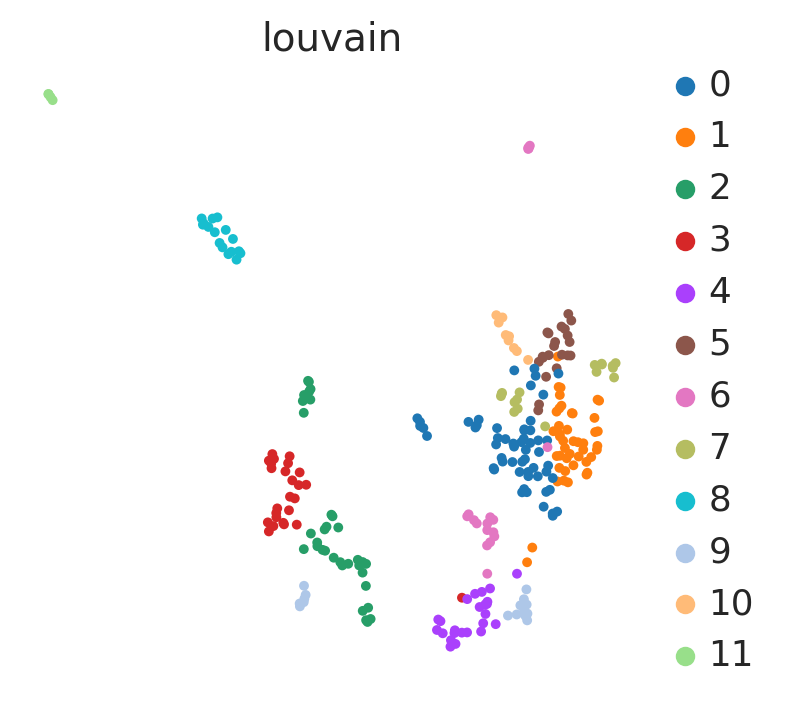

In [25]:
sc.pl.umap(adata_comb, color="louvain", size=50)

### Mean gene expression for each condition

In [ ]:
adata[adata.obs.condition == i for i in adata.obs.condition.unique]

In [ ]:
adata_mean = sc.AnnData(np.array(means).reshape(284,5000), obs={"condition":list(adata.obs.condition.unique())})

In [45]:
means = [adata[adata.obs.condition == i].X.mean(axis=0) for i in adata.obs.condition.unique()]

In [63]:
adata_mean = sc.AnnData(np.array(means).reshape(284,5000), obs={"condition":list(adata.obs.condition.unique())})

In [66]:
sc.pp.neighbors(adata_mean,n_neighbors=6, metric="cosine",use_rep='X')
sc.tl.louvain(adata_mean, resolution=0.7)

In [67]:
sc.tl.umap(adata_mean)

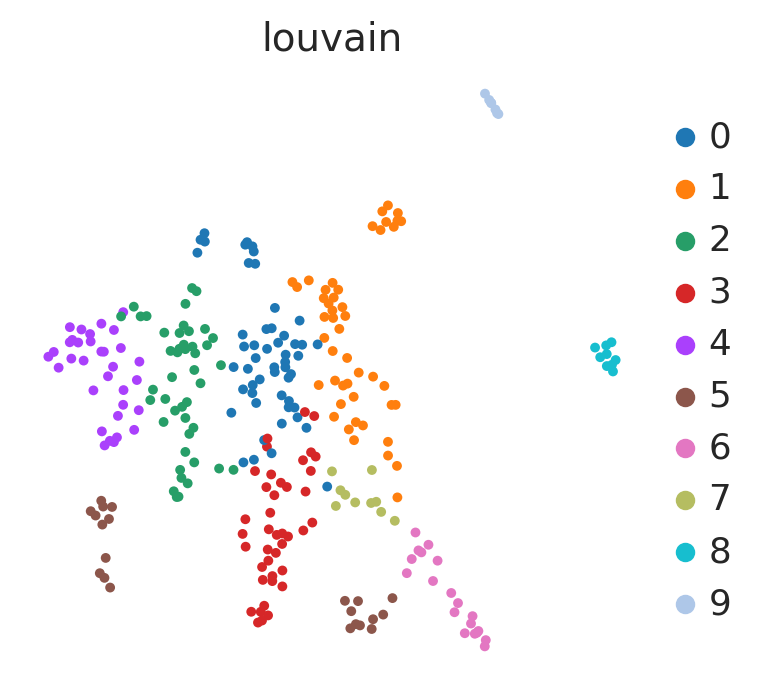

In [68]:
sc.pl.umap(adata_mean, color="louvain", size=50)

In [69]:
umap_mean = dict(zip(adata_mean.obs[condition_key], adata_mean.obsm['X_umap']))

In [26]:
def plot_latent(drug_emb_pca, #dictionary of embedding coordinates
                col_dict=None, #dictionary for dots color, default='dark gray'
                col_dict_pathway=None, 
                current_palette=None, #palette for the drugs
                plot_drug_list=['control'], #names of drugs to put on the plot
                title='Drug latent space',
                bold_names=['control', 'ctrl'], #names of drugs to be desplayed in bold font
                col_dict_face=None, #dictionary for text color, default='black'
                fs=9, # fontsize for text
                s1=8.5, s2=6, #figure size in inches
                fname=None,
                plotline=False, #set true if you want to see vectors from 0
                format='png'):
    
    sns.set_style("whitegrid", {'axes.grid' : False})

    atomic_drugs = list(drug_emb_pca.keys())
    
    if col_dict is None:
        if current_palette is None:
            current_palette = ['#636363']*len(atomic_drugs)
        col_dict = dict(zip(atomic_drugs, current_palette[:len(atomic_drugs)]))

    if col_dict_face is None:
        col_dict_face = dict(zip(atomic_drugs, ['#000000']*len(atomic_drugs)))
    
    fig = plt.figure(figsize=(s1, s2))
    gs = gridspec.GridSpec(1, 2, width_ratios=[7, 1])
    ax = plt.subplot(gs[0])
    ax.grid('off')
    ax.axis('off')
    for i, drug in enumerate(atomic_drugs):
        if plotline:
            ax.plot([0, drug_emb_pca[drug][0]], [0, drug_emb_pca[drug][1]], 
                     color=col_dict[drug], alpha=0.15, linewidth=0.8)
        ax.scatter(drug_emb_pca[drug][0], drug_emb_pca[drug][1], alpha=0.9, s=10, color=col_dict[drug])

    ax.axis('equal')
    ax.grid('off')
    ax.set_title(title, fontsize=fs,fontweight="bold")
    ax.xaxis.set_tick_params(labelsize=fs)
    ax.yaxis.set_tick_params(labelsize=fs)
    sns.despine(left=True, bottom=True, right=True)
    
    texts = []
    for l, drug in enumerate(atomic_drugs):
        if drug in plot_drug_list:
            if drug in bold_names:
                texts.append(ax.text(drug_emb_pca[drug][0], drug_emb_pca[drug][1], 
                                 drug, fontsize=fs, color=col_dict_face[drug], fontweight="bold"))
            else:
                texts.append(ax.text(drug_emb_pca[drug][0], drug_emb_pca[drug][1], 
                                     drug, fontsize=fs, color=col_dict_face[drug]))
        
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.1))
    
    if not (col_dict_pathway is None):
        ax = plt.subplot(gs[1])
        texts = []
        eps = -1e-3
        i = 0
        mx = 0
        my = 0
        for p in col_dict_pathway.keys():
            if (p != 'Vehicle') and (p != 'NA') and (p != 'DMSO') and (p != 'control'):
                props = dict(boxstyle='round', facecolor=col_dict_pathway[p], alpha=0.6)
                texts.append(ax.text(mx + 0.5, my + i*0.045, p, fontsize=fs, 
                                      color='black', bbox=props))
                i += 1
    #     adjust_text(texts)
        ax.set_ylim([0, my  + i*0.045])
        ax.axis('off')
        sns.despine(left=True, bottom=True, right=True)

    plt.tight_layout()
    ax.grid('off')
    ax.axis('off')
    plt.show()

    if fname:
        print(fname)
        fig.savefig(f'{fname}.{format}', format=format)


In [27]:
all_colors = {k:"#DCDCDC" for k in adata.obs["condition"].unique()}

In [28]:
dict_class = {'MEGAKARYOCYTE': MEGAKARYOCYTE,
 'PRO_GROWTH': PRO_GROWTH,
 'GRANULOCYTE_APOPTOSIS': GRANULOCYTE_APOPTOSIS,
 'PIONEER_FACTORS': PIONEER_FACTORS,
 'ERYTHROID': ERYTHROID,
 'g1_cycle': g1_cycle}

In [29]:
col_dict_class = {'MEGAKARYOCYTE': '#cc79a7',
 'PRO_GROWTH': 'purple',
 'GRANULOCYTE_APOPTOSIS': 'green',
 'PIONEER_FACTORS': '#0072b2',
 'ERYTHROID': 'orange',
 'g1_cycle': 'brown'}

In [176]:
data = [adata_comb, adata_mean]

for ad in data:
    all_labels = []
    flag = 0
    for ko in ad.obs.condition:
        flag = 0
        for ko_cls in dict_class.keys():
            if ko in dict_class[ko_cls]:
                all_labels.append(ko_cls)
                flag = 1
        if flag == 0:
            all_labels.append("unknown")

    ad.obs["gene_programm"] = all_labels

In [213]:
res = [0.3, 0.4, 0.5, 0.6, 0.7,0.75, 0.8,0.85, 0.9, 1]
knn = [3,4,5,6,8,7,8,9,10]

0.34452952787282065


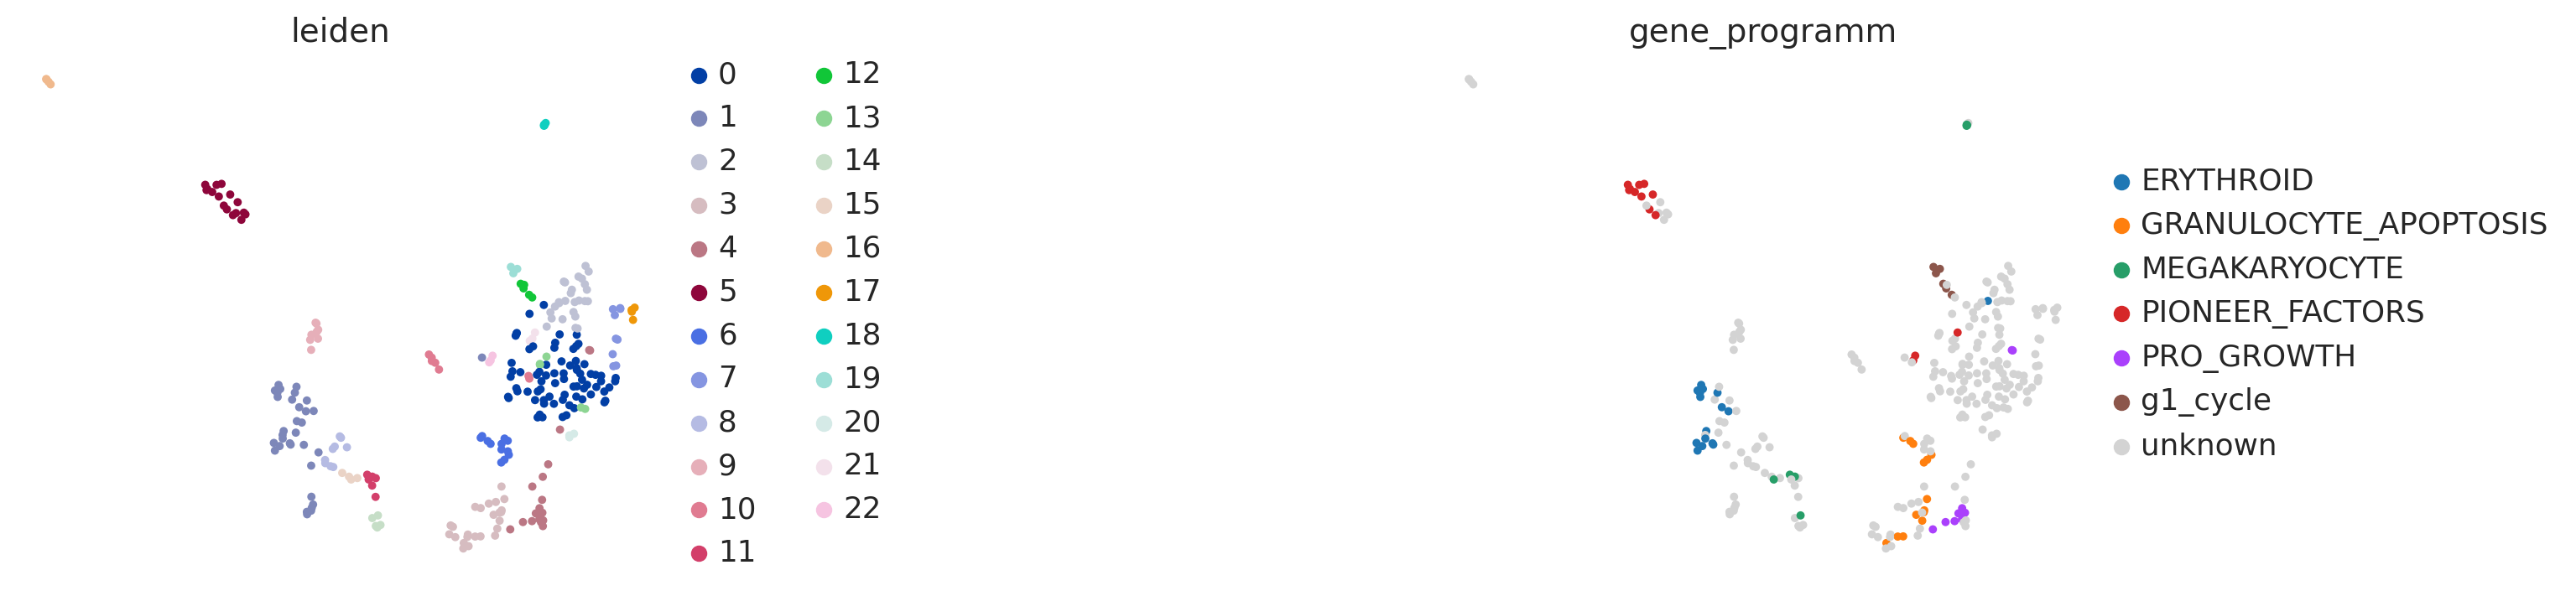

homogeneity_score_gp:0.6573230736786617


In [634]:
score_combo = {}
for i in res: 
    for k in knn:
        sc.pp.neighbors(adata_comb, metric="cosine", n_neighbors=k,)
        sc.tl.leiden(adata_comb, resolution=i)
        score_combo[f"{i}+{k}"] = normalized_mutual_info_score(adata_comb.obs.gene_programm, adata_comb.obs.leiden)
print(np.max(list(score_combo.values())))
arg_max = np.argmax(list(score_combo.values()))
sc.pp.neighbors(adata_comb, metric="cosine", n_neighbors=int(list(score_combo.keys())[arg_max].split("+")[1]))
sc.tl.leiden(adata_comb, resolution= float(list(score_combo.keys())[arg_max].split("+")[0]))
sc.pl.umap(adata_comb, color=["leiden", "gene_programm"], size=50, wspace=1)
print(f"homogeneity_score_gp:{homogeneity_score(adata_comb.obs.gene_programm, adata_comb.obs.leiden)}")

0.3540838476776155
15


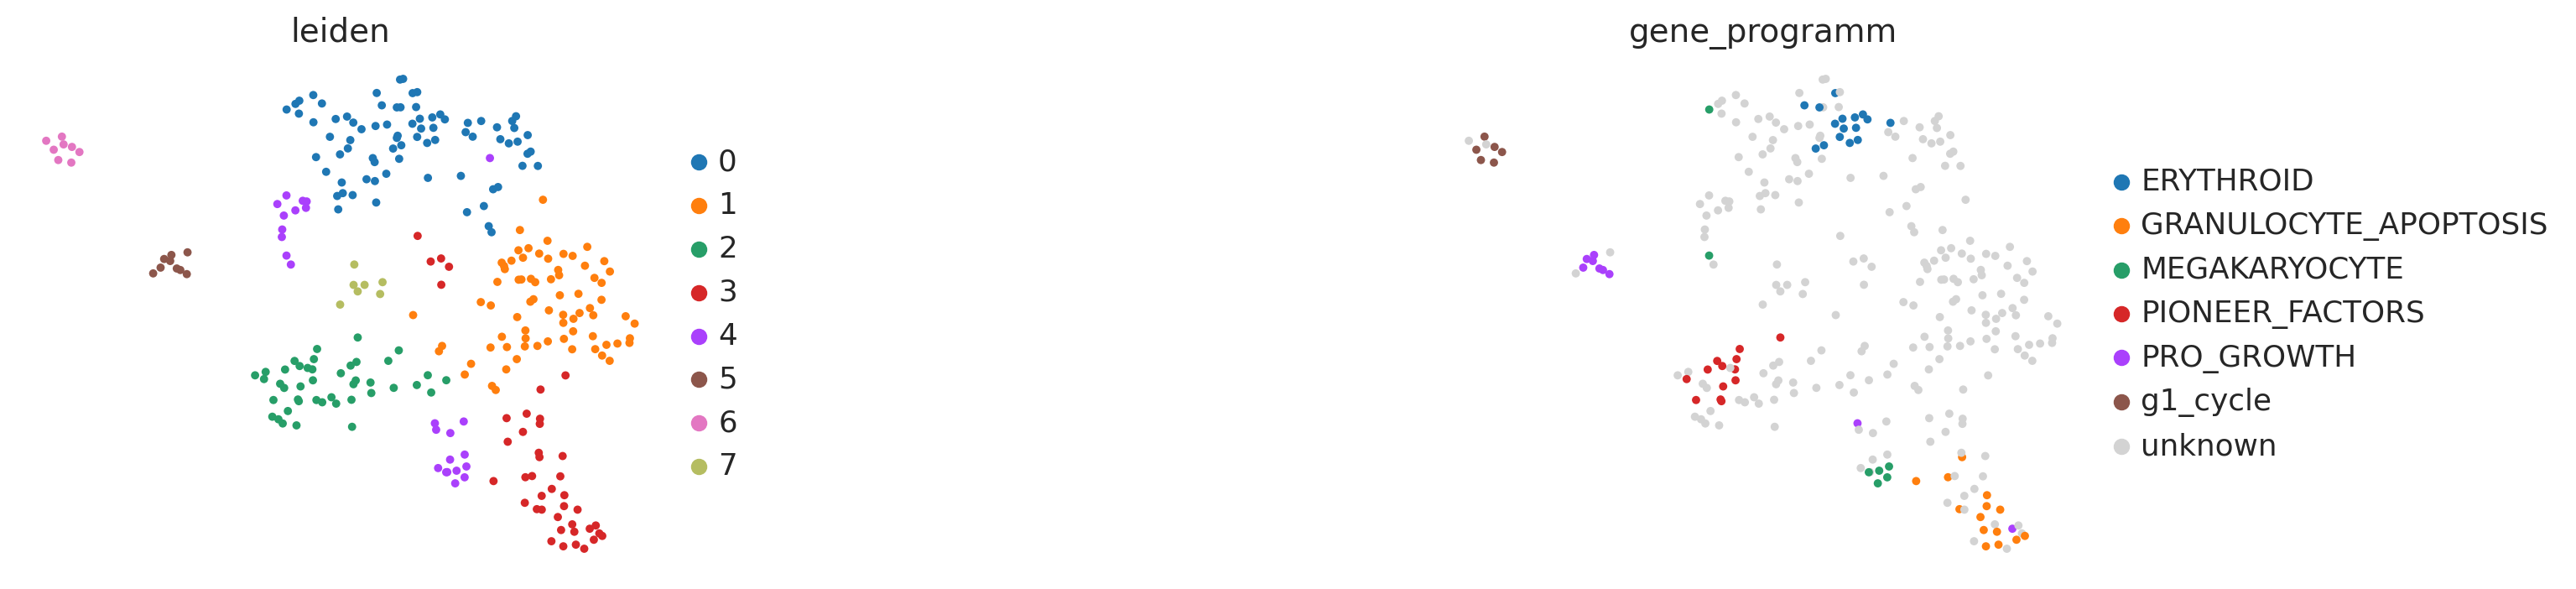

homogeneity_score_gp: 0.5152335549570954


In [635]:
score_mean = {}
for i in res: 
    for k in knn:
        sc.pp.neighbors(adata_mean, metric="cosine", n_neighbors=k)
        sc.tl.leiden(adata_mean, resolution=i)
        score_mean[f"{i}+{k}"] = normalized_mutual_info_score(adata_mean.obs.gene_programm, adata_mean.obs.leiden)
print(np.max(list(score_mean.values())))
arg_max = np.argmax(list(score_mean.values()))
print(arg_max)
sc.pp.neighbors(adata_mean, metric="cosine", n_neighbors=int(list(score_mean.keys())[arg_max].split("+")[1]))
sc.tl.leiden(adata_mean, resolution= float(list(score_mean.keys())[arg_max].split("+")[0]))
sc.pl.umap(adata_mean, color=["leiden", "gene_programm"], size=50,  wspace=1)
print(f"homogeneity_score_gp: {homogeneity_score(adata_mean.obs.gene_programm, adata_mean.obs.leiden)}")

Cross cluster comparison 

In [636]:
combo = adata_comb.obs[["condition","leiden"]].set_index('condition')['leiden'].to_dict()
ge = adata_mean.obs[["condition","leiden"]].set_index('condition')['leiden'].to_dict()

ge_cluster_for_comb = []
for i in adata_comb.obs.condition:
       ge_cluster_for_comb.append(ge[i]) 
        
combo_cluster_for_ge = []
for i in adata_mean.obs.condition:
       combo_cluster_for_ge.append(combo[i]) 
        
adata_comb.obs["leiden_GE"] = ge_cluster_for_comb
adata_mean.obs["leiden_CPA"] = combo_cluster_for_ge


In [637]:
adata_comb.uns["leiden_GE_colors"] = adata_mean.uns["leiden_colors"]

In [638]:
adata_comb.uns["gene_programm_colors"] = ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#d3d3d3']
adata_mean.uns["gene_programm_colors"] = ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b', '#d3d3d3']

... storing 'leiden_CPA' as categorical


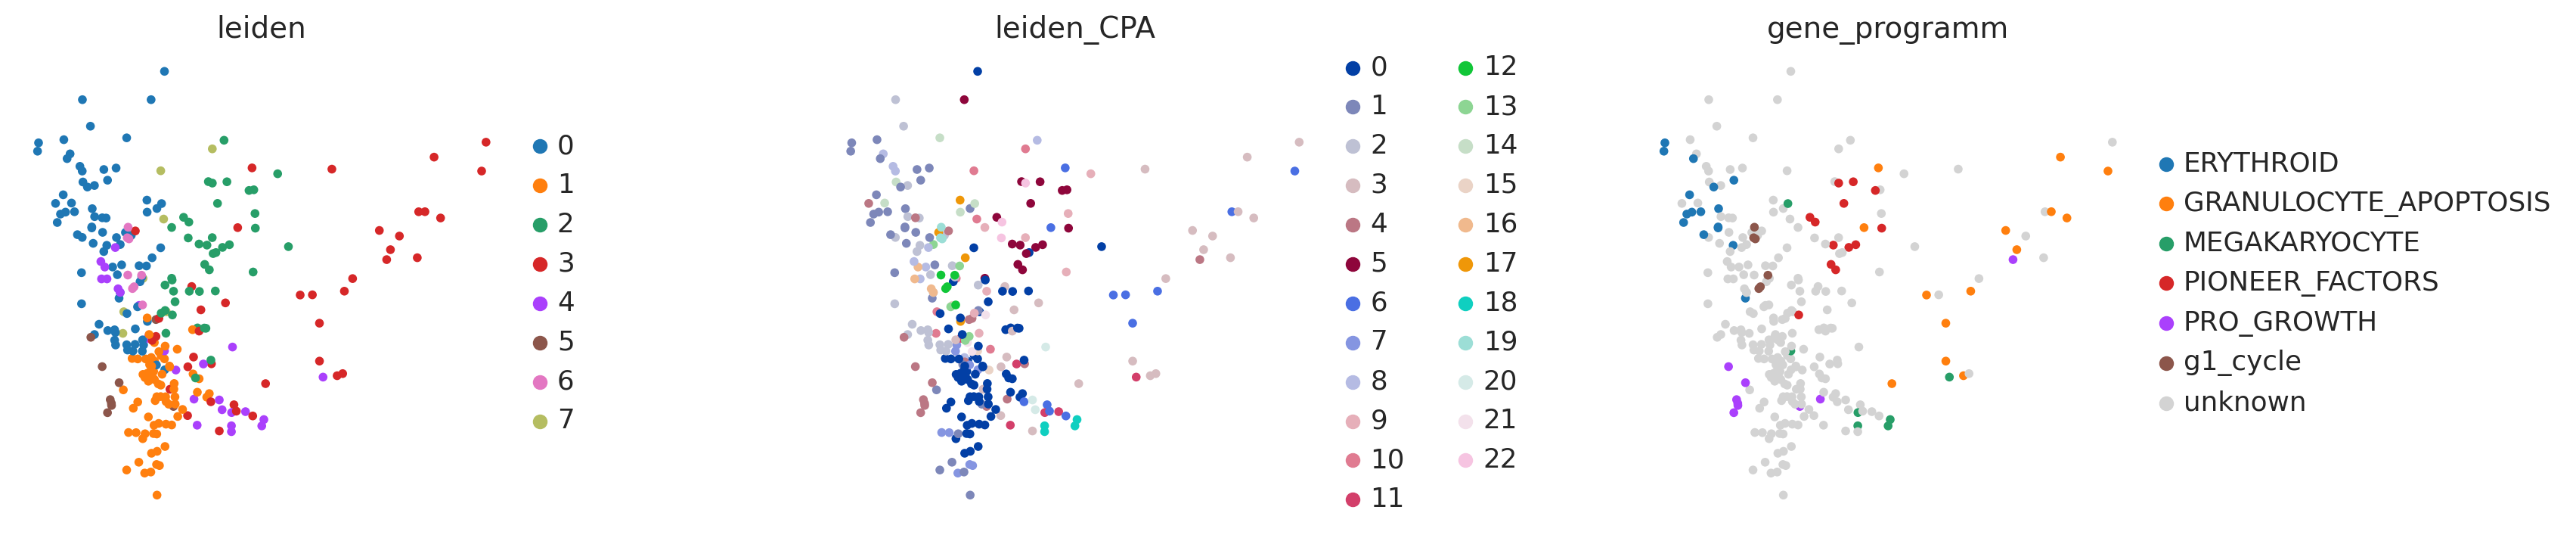

In [639]:
sc.pl.pca(adata_mean, color=["leiden", "leiden_CPA", "gene_programm"],
           size=70,  wspace=0.5, save="clustering_ge_pca.pdf")

... storing 'leiden_GE' as categorical


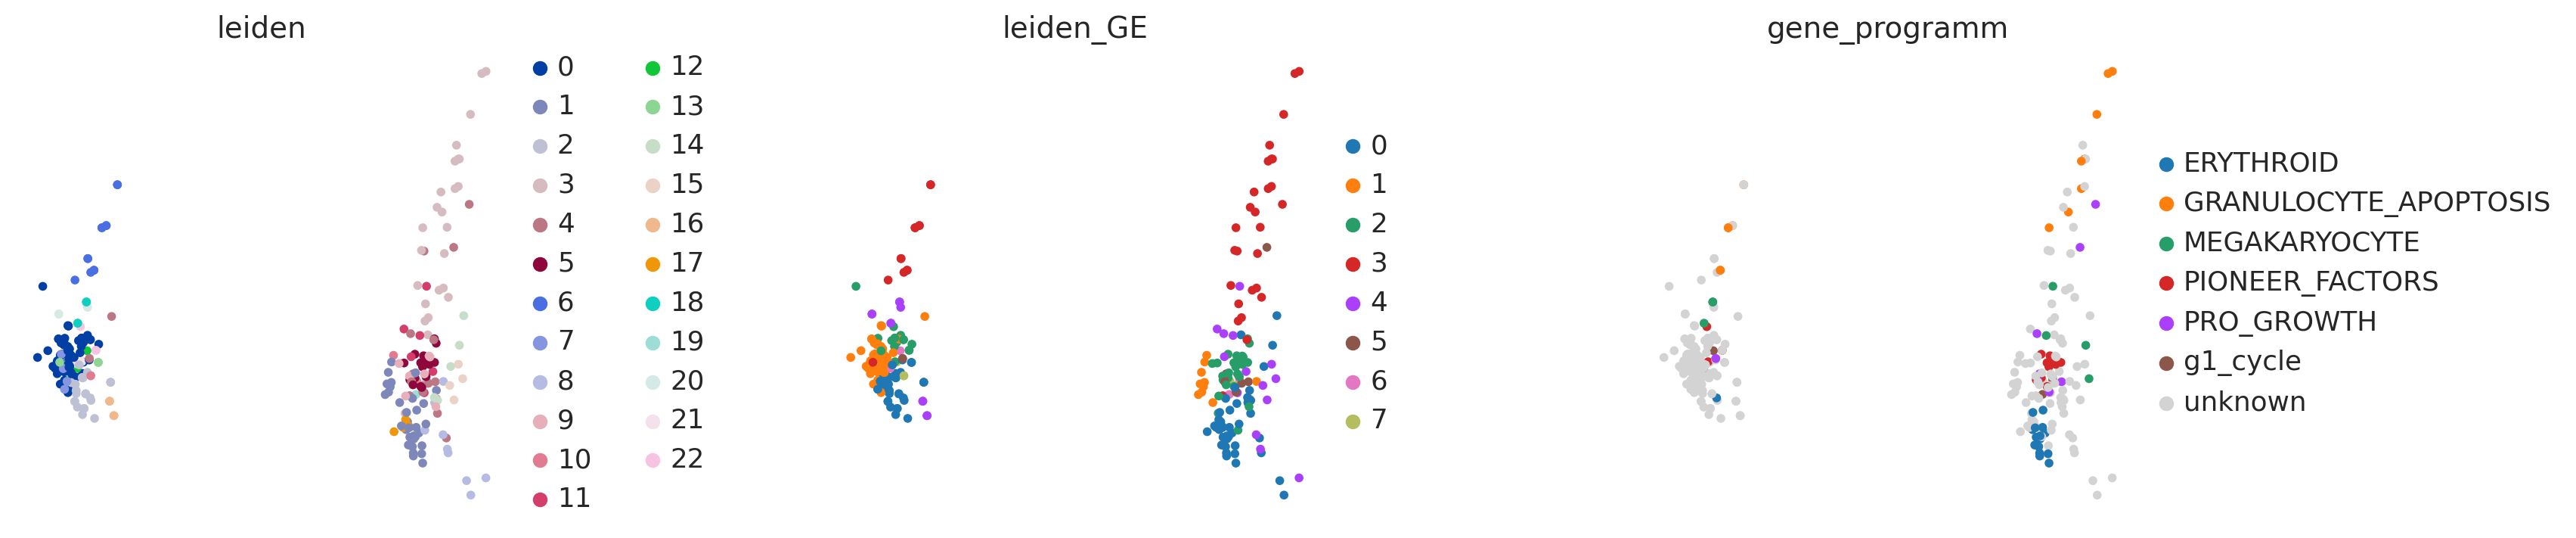

In [640]:
sc.pl.pca(adata_comb, color=["leiden", "leiden_GE", "gene_programm"],
           size=70,  wspace=0.5, save="clustering_pca_cpa.pdf")#CPA


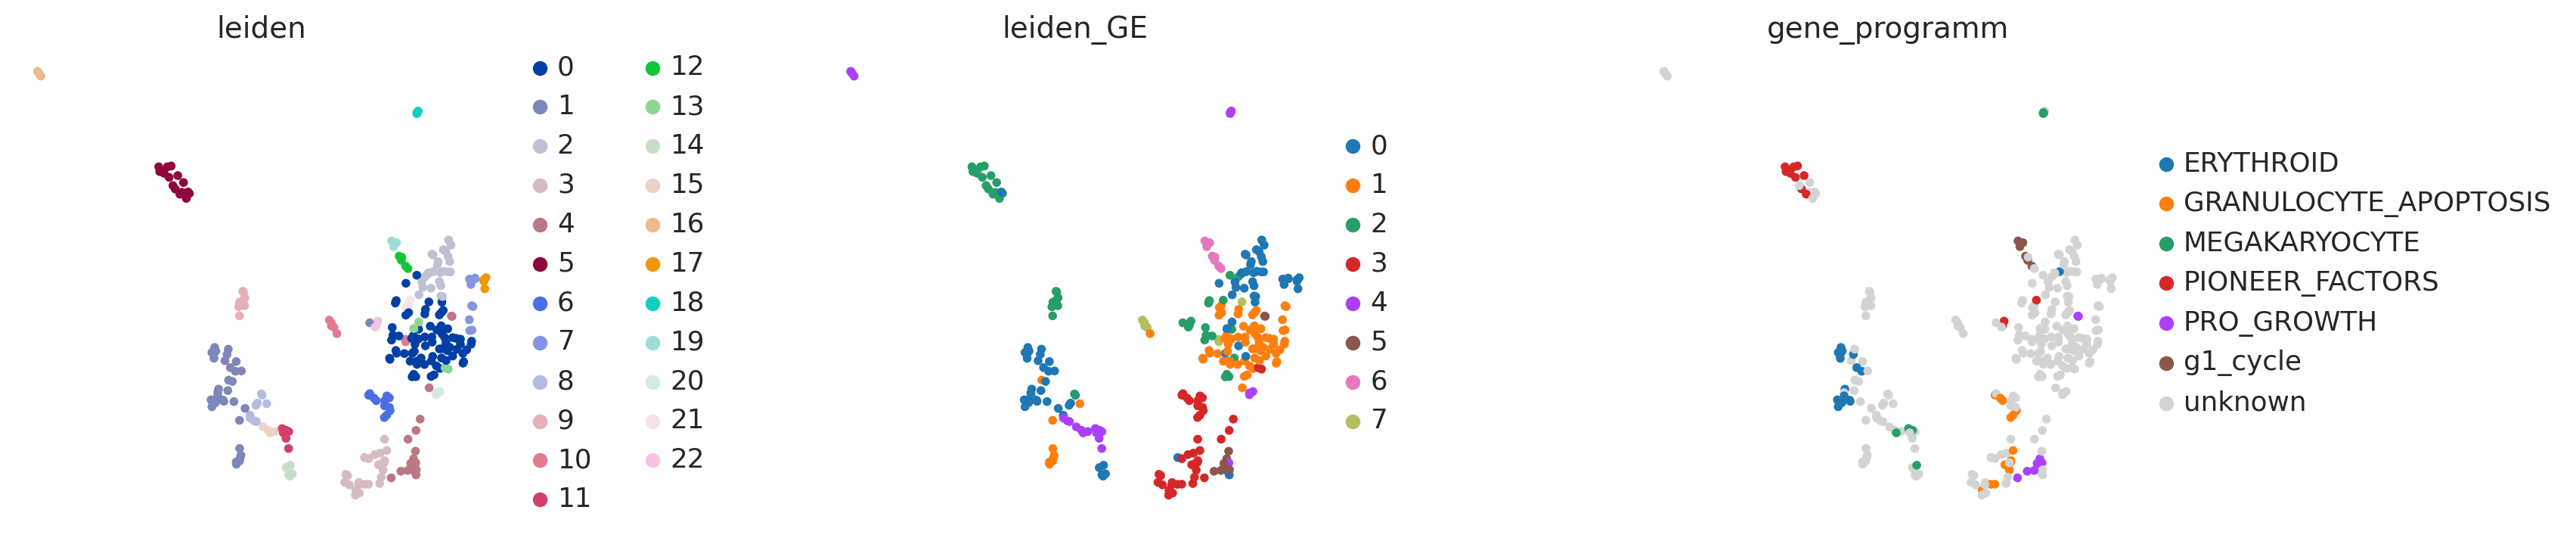

overalhomogeneity_score_gp_CPA:0.6573230736786617
ASW_score_CPA:0.16684900224208832


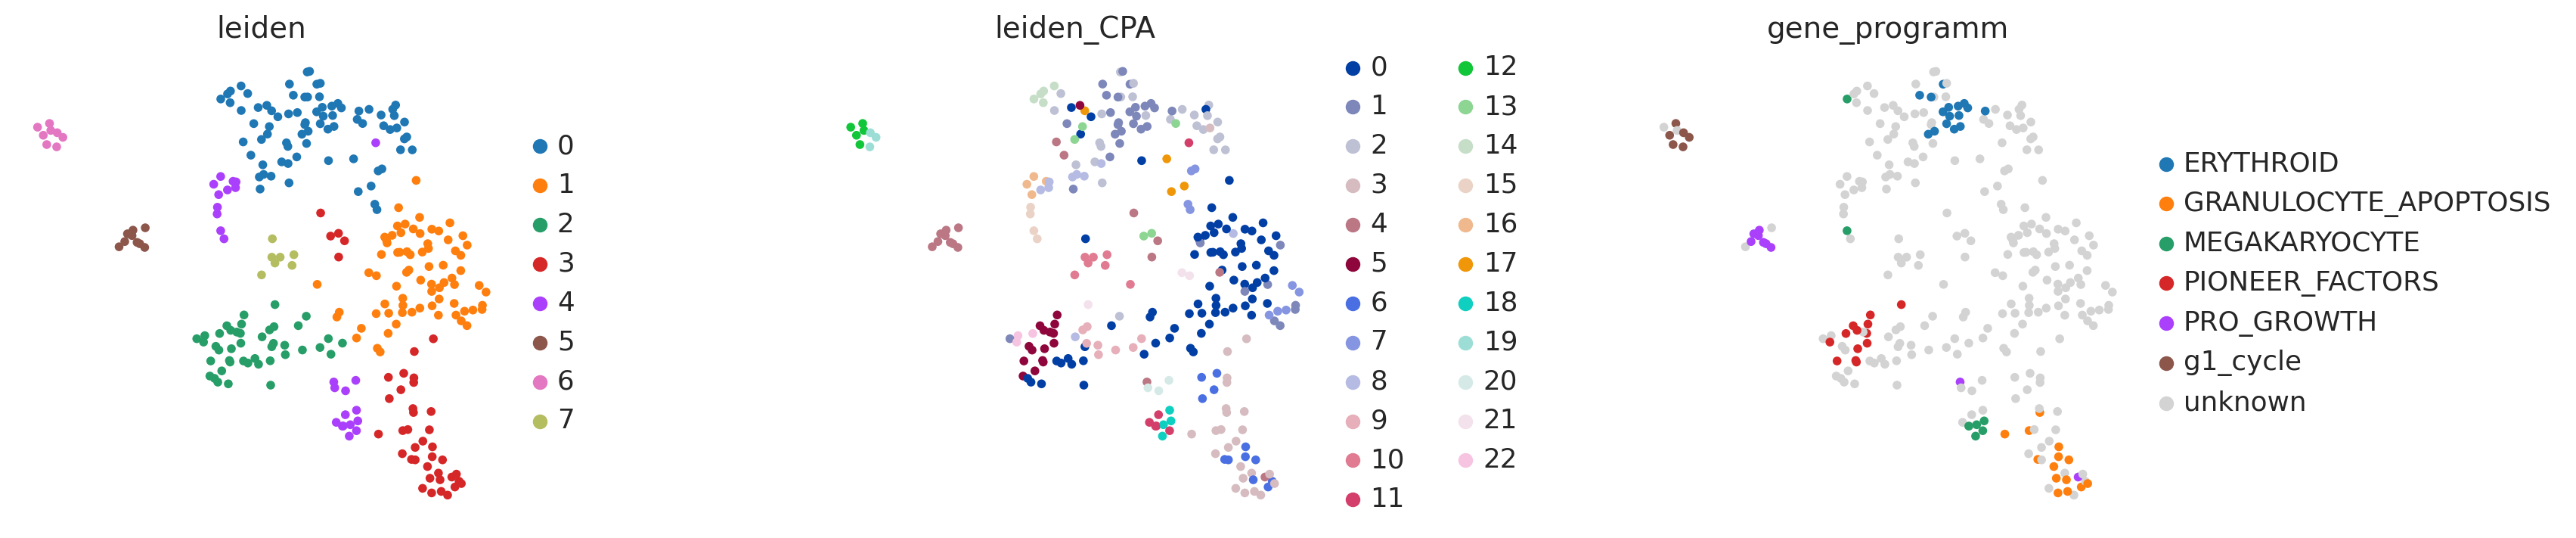

overal homogeneity_score_gp_GE: 0.5152335549570954
ASW_score_GE_mean:0.09384069591760635


In [641]:
sc.pl.umap(adata_comb, color=["leiden", "leiden_GE", "gene_programm"], 
           size=70,  wspace=0.5,save="clustering_cpa.pdf")
print(f"overalhomogeneity_score_gp_CPA:{homogeneity_score(adata_comb.obs.gene_programm, adata_comb.obs.leiden)}")
x_cpa = adata_comb.obsm["X_pca"]
print(f"ASW_score_CPA:{silhouette_score(x_cpa, adata_comb.obs.leiden)}")


#GE mean
sc.pl.umap(adata_mean, color=["leiden", "leiden_CPA", "gene_programm"],
           size=70,  wspace=0.5, save="clustering_ge.pdf")
x_mean = adata_mean.obsm["X_pca"]
print(f"overal homogeneity_score_gp_GE: {homogeneity_score(adata_mean.obs.gene_programm, adata_mean.obs.leiden)}")
print(f"ASW_score_GE_mean:{silhouette_score(x_mean, adata_mean.obs.leiden)}")

## Ploting metrics 

In [642]:
import pandas as pd 
import seaborn as sns

In [643]:
score = {'score': [0.16,0.09,0.65, 0.51], 'type':["ASW", "ASW", "Homogeneity","Homogeneity" ],
     "model":["CPA", "mean_GE", "CPA", "mean_GE"]}
pd.DataFrame(data=d)

,score,type,model
0,0.16,ASW,CPA
1,0.09,ASW,CPA
2,0.65,Homogeneity,mean_GE
3,0.51,Homogeneity,mean_GE


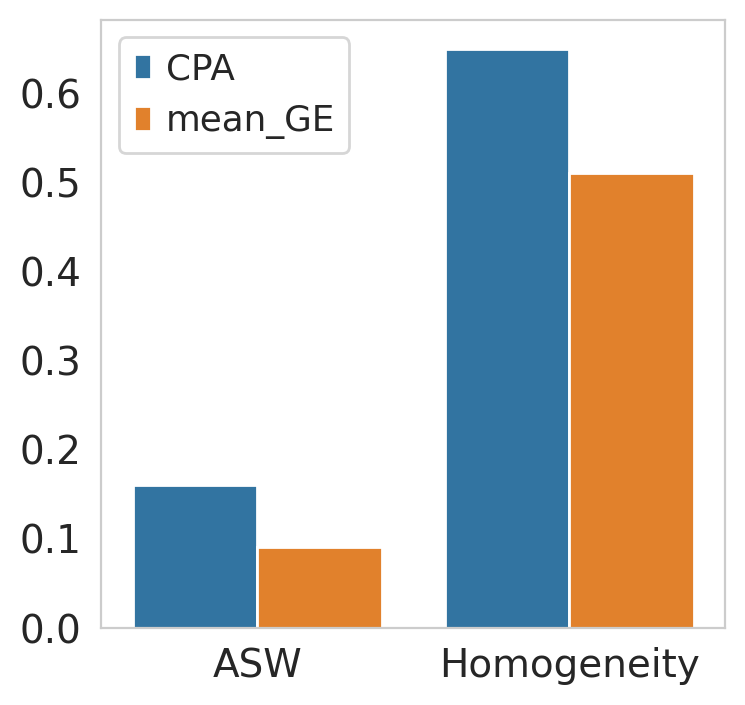

In [644]:
ax = sns.barplot(x="type", y="score", data=score, hue="model")
fig = ax.get_figure()
fig.savefig("./figures/clust_score.pdf")
